In [1]:
import sys
sys.path.append("../")

,image_name,label,path,train,label_id,image_id
0,image25107.jpg,apparel,images/apparel/image25107.jpg,True,9,0
1,image26799.jpg,apparel,images/apparel/image26799.jpg,True,9,1
2,image23088.jpg,apparel,images/apparel/image23088.jpg,True,9,2
3,image0421.jpg,apparel,images/apparel/image0421.jpg,True,9,3


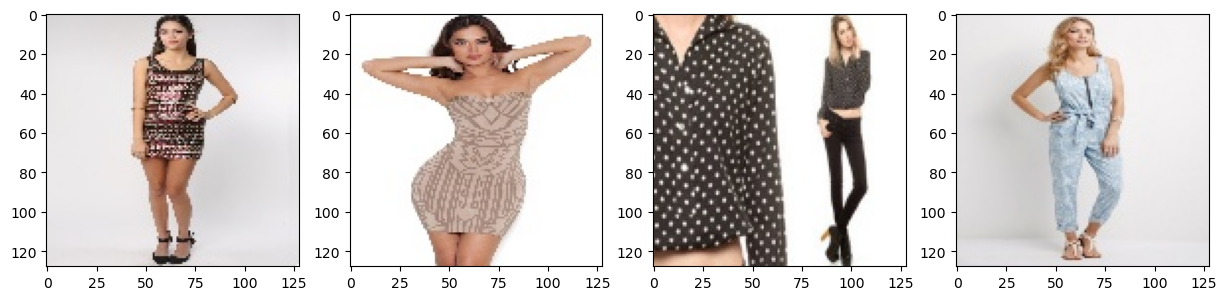

In [2]:
import cv2                      # Image Ops
import pandas as pd             # Other
import numpy as np              # Mat Opts
import matplotlib.pyplot as plt # Show Images

from utils.utils import load_images
from utils.features import load_features, save_features, extract_features
from utils.matching import minmin_retrival, match_all_images
from utils.scoring import calculate_metrics

image_meta, images = load_images(True) # True - Train Images
display(image_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(images[0]);
ax[1].imshow(images[1]);
ax[2].imshow(images[2]);
ax[3].imshow(images[3]);

In [8]:
def sift_descriptor(image, octaves: int = 6, thress: float = 0.05):
    orb = cv2.SIFT_create(nfeatures = 50,  nOctaveLayers = octaves, contrastThreshold = thress, edgeThreshold = 10, sigma = 1.6  )
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descs = orb.detectAndCompute(img, None)
    return descs

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
print("Tamaño de  descriptores:", descriptors.shape[1])
print("Número de  descriptores:", descriptors.shape[0])
print("Número Máximo de Descriptores Por Imágen :", pd.value_counts(index).max())
print("Número Medio  de Descriptores Por Imágen :", pd.value_counts(index).mean().round(0).astype(int))
print("Número Mínimo de Descriptores Por Imágen :", pd.value_counts(index).min())

# Obligatorio Siempre Guardar
save_features(descriptors, index, image_meta, "SIFT-COV")

  0%|          | 0/550 [00:00<?, ?it/s]

Tamaño de  descriptores: 128
Número de  descriptores: 27030
Número Máximo de Descriptores Por Imágen : 53
Número Medio  de Descriptores Por Imágen : 49
Número Mínimo de Descriptores Por Imágen : 10


In [9]:
desc_meta, descriptors = load_features("../features/SIFT-COV.csv") # Siempre Cargar
display(desc_meta.head())
display(descriptors.dtype)

,image_id,label_id
0,0,9
1,0,9
2,0,9
3,0,9
4,0,9


dtype('float32')

,image_name,label,path,train,label_id,image_id
0,image6479.jpg,apparel,images/apparel/image6479.jpg,False,9,0
1,image2791.jpg,apparel,images/apparel/image2791.jpg,False,9,1
2,image9608.jpg,apparel,images/apparel/image9608.jpg,False,9,2
3,image26288.jpg,apparel,images/apparel/image26288.jpg,False,9,3


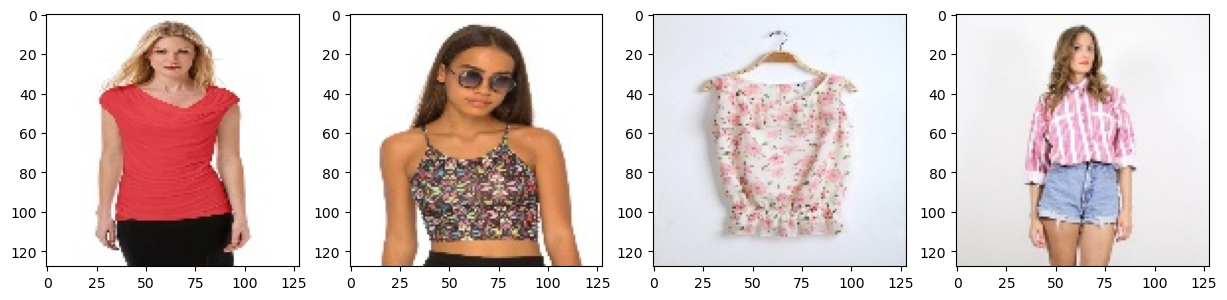

In [10]:
test_meta, test_images = load_images(False)

display(test_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(test_images[0]);
ax[1].imshow(test_images[1]);
ax[2].imshow(test_images[2]);
ax[3].imshow(test_images[3]);


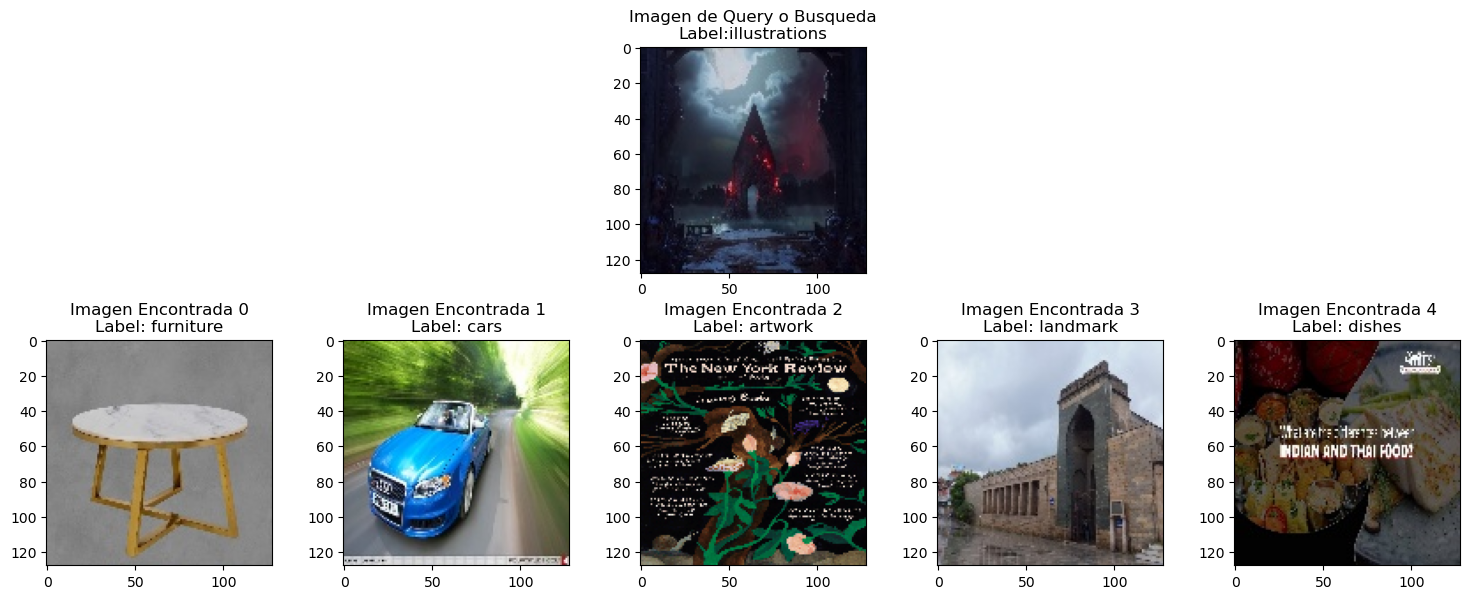

In [11]:
img = test_images[50]
descs = sift_descriptor(img)
ret_idx = minmin_retrival(descs, descriptors, desc_meta, best_k=5)

fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

test_img = 50
ax[0][2].imshow(img)
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(ret_idx[:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


  0%|          | 0/110 [00:00<?, ?it/s]

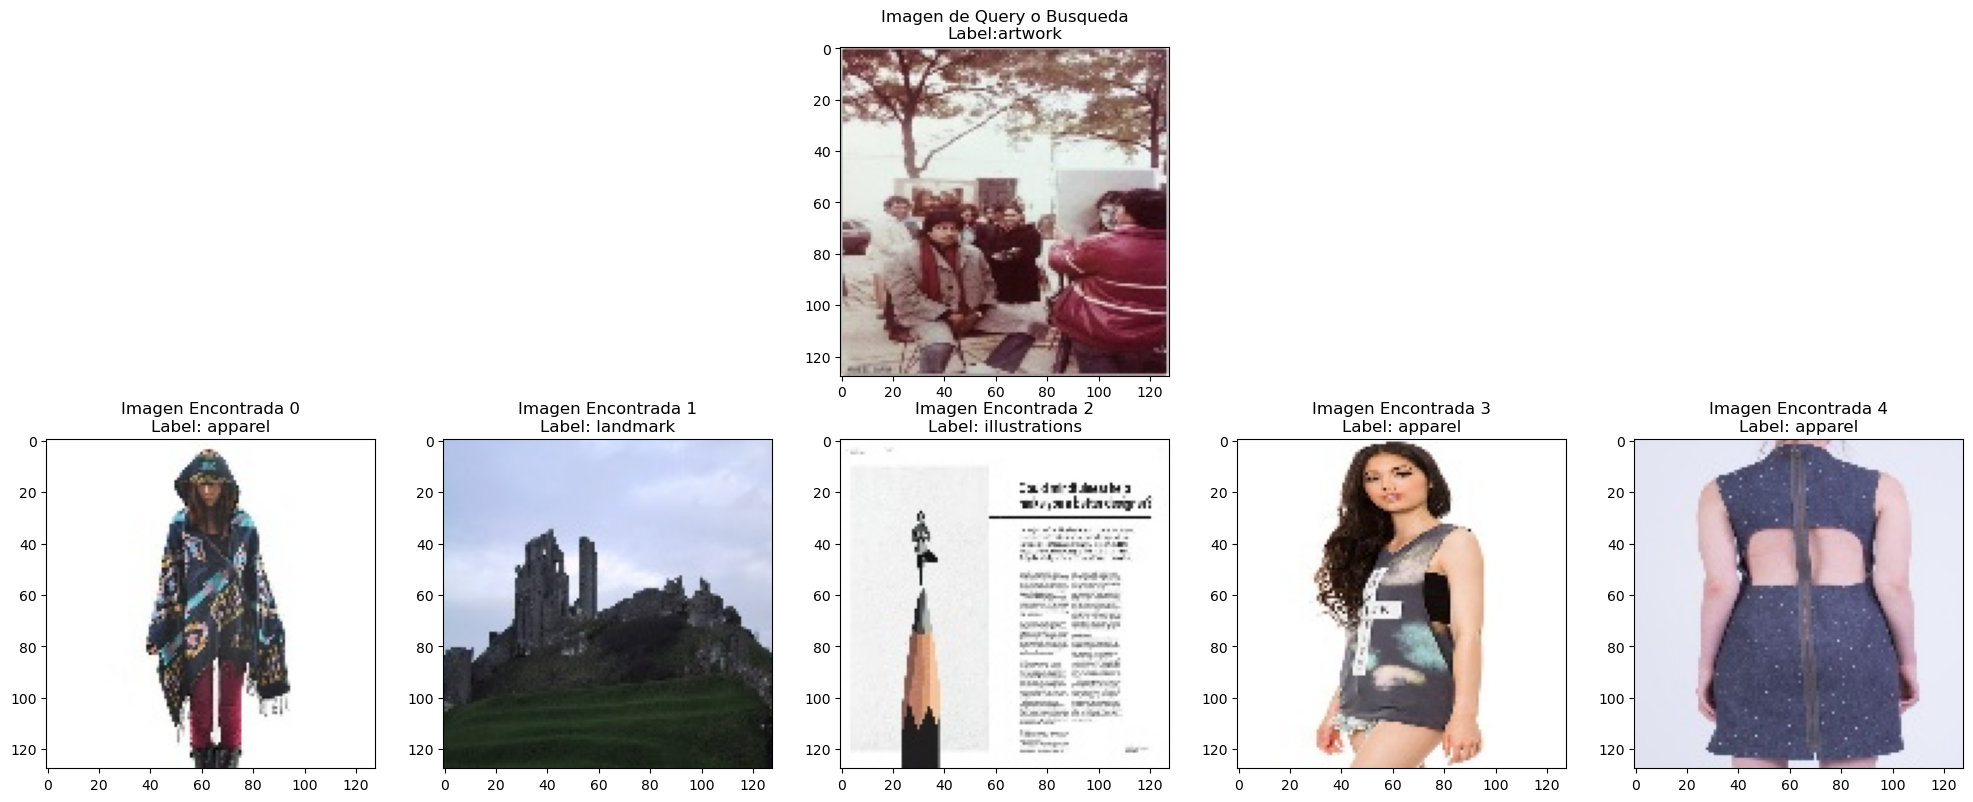

In [12]:
test_decs, test_desc_meta = extract_features(sift_descriptor, test_images, progress=True)

xr = match_all_images(test_decs, test_meta, descriptors, desc_meta, best_k=10, distance_function=cv2.NORM_L1)
fig, ax = plt.subplots(2, 5,  figsize = (20, 8))

test_img = 10
ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(xr[test_img][:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [13]:
calculate_metrics(xr, image_meta, test_meta, scores = (1, 5, 10))

,Precision@K,Recall@K,R-Precision@K
K,,,
1,0.100000,0.002000,0.100000
5,0.094545,0.009455,0.094545
10,0.097273,0.019455,0.097273


In [18]:
from sklearn.cluster import KMeans
K = 50
vocab_model = KMeans(n_clusters=K, init = 'k-means++', random_state = 20010)
vocab_model = vocab_model.fit(descriptors)

In [19]:
vocab_model

KMeans(n_clusters=50, random_state=20010)

In [20]:
pd.DataFrame(descriptors)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,6.0,38.0,124.0,22.0,1.0,5.0,9.0,1.0,133.0,133.0,...,66.0,17.0,9.0,3.0,1.0,26.0,34.0,25.0,17.0,13.0
1,25.0,6.0,1.0,12.0,33.0,24.0,16.0,33.0,40.0,16.0,...,2.0,9.0,50.0,143.0,1.0,0.0,0.0,0.0,0.0,1.0
2,54.0,11.0,0.0,0.0,7.0,77.0,18.0,11.0,133.0,52.0,...,0.0,0.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,18.0,0.0,3.0,36.0,21.0,1.0,1.0,164.0,44.0,...,13.0,17.0,96.0,35.0,9.0,3.0,4.0,1.0,0.0,4.0
4,0.0,0.0,0.0,6.0,5.0,0.0,0.0,0.0,6.0,3.0,...,3.0,53.0,10.0,7.0,5.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27025,0.0,0.0,0.0,87.0,92.0,0.0,0.0,0.0,9.0,1.0,...,4.0,13.0,0.0,0.0,3.0,98.0,27.0,6.0,4.0,4.0
27026,3.0,1.0,0.0,37.0,136.0,1.0,0.0,0.0,136.0,15.0,...,0.0,15.0,75.0,7.0,2.0,1.0,0.0,1.0,12.0,23.0
27027,0.0,0.0,0.0,76.0,130.0,0.0,0.0,0.0,25.0,6.0,...,0.0,33.0,25.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0
27028,50.0,64.0,3.0,3.0,71.0,46.0,10.0,12.0,22.0,1.0,...,1.0,2.0,20.0,59.0,21.0,46.0,22.0,4.0,1.0,3.0


In [22]:
from sklearn.preprocessing import normalize
descriptors, index = extract_features(sift_descriptor, images, min_features=3, progress = True)

idxs = {}
for i, item in enumerate(index):
    if item not in idxs: idxs[item] = []
    idxs[item].append(i)

pairs = {}
for image_id, idx in idxs.items():
    vocab = vocab_model.predict(descriptors[idx])
    vocab = np.bincount(vocab, minlength=K)
    pairs[image_id] = normalize( vocab.reshape((1, -1)) ).reshape((-1))

print(image_id)


  0%|          | 0/550 [00:00<?, ?it/s]

549


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.359211,0.269408,0.000000,0.179605,0.089803,0.000000,0.089803,0.089803,0.089803,0.089803,...,0.179605,0.000000,0.449013,0.000000,0.000000,0.000000,0.269408,0.179605,0.000000,0.000000
1,0.000000,0.083045,0.000000,0.332182,0.000000,0.249136,0.000000,0.249136,0.000000,0.000000,...,0.166091,0.083045,0.166091,0.000000,0.083045,0.083045,0.166091,0.498273,0.083045,0.000000
2,0.000000,0.075378,0.000000,0.527645,0.000000,0.301511,0.150756,0.000000,0.000000,0.075378,...,0.000000,0.000000,0.075378,0.000000,0.000000,0.452267,0.000000,0.150756,0.000000,0.000000
3,0.085749,0.257248,0.000000,0.085749,0.171499,0.000000,0.085749,0.085749,0.171499,0.171499,...,0.171499,0.085749,0.000000,0.000000,0.171499,0.000000,0.000000,0.171499,0.000000,0.000000
4,0.000000,0.096225,0.096225,0.000000,0.096225,0.192450,0.288675,0.096225,0.096225,0.096225,...,0.000000,0.096225,0.096225,0.288675,0.000000,0.192450,0.000000,0.000000,0.096225,0.096225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0.000000,0.202031,0.101015,0.000000,0.000000,0.202031,0.202031,0.101015,0.000000,0.404061,...,0.202031,0.000000,0.202031,0.000000,0.202031,0.202031,0.202031,0.000000,0.202031,0.000000
546,0.145865,0.000000,0.072932,0.000000,0.072932,0.072932,0.072932,0.510527,0.072932,0.000000,...,0.072932,0.000000,0.000000,0.000000,0.072932,0.000000,0.072932,0.000000,0.072932,0.364662
547,0.326599,0.000000,0.000000,0.244949,0.000000,0.000000,0.081650,0.571548,0.000000,0.000000,...,0.081650,0.163299,0.244949,0.000000,0.000000,0.000000,0.081650,0.000000,0.000000,0.163299
548,0.382360,0.076472,0.076472,0.000000,0.000000,0.076472,0.000000,0.152944,0.305888,0.152944,...,0.229416,0.000000,0.000000,0.000000,0.000000,0.000000,0.229416,0.076472,0.076472,0.000000


In [23]:
pd.DataFrame.from_dict(pairs, orient = 'index').to_csv('sift-1b7852b855-vocab-50.csv')

In [26]:
from pickle import dump
dump(vocab_model, open('../model/sift-1b7852b855-vocab-50.sav', 'wb'))

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import normalize
ret = []
for i, img in tqdm(enumerate(images), total = 550):
    descriptores = sift_descriptor(img)
    if descriptores is None: continue
    vocab = vocab_model.predict(descriptores)
    vocab = np.bincount(vocab, minlength=K)
    ret.append( normalize( vocab.reshape((1, -1)) ) )

100%|██████████| 550/550 [00:05<00:00, 93.54it/s]
